In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',download=True, train=False, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')


Processing...
Done!


In [4]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2+0.5 
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))
        
    

In [4]:
torch.cuda.empty_cache()

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()

In [7]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [8]:
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = .001, momentum=0.9)

In [10]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment')

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('four_fashion_mnist_images', img_grid)

In [7]:
from __future__ import print_function, division
import time
import os
import copy

In [11]:
for epoch in range(25):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        
        inputs, labels = data[0].to(device), data[1].to(device) 
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1,  i + 1, running_loss/2000))
            running_loss = 0.0

            
print('finished training')

[1,  1000] loss: 0.958
[1,  2000] loss: 0.441
[1,  3000] loss: 0.365
[1,  4000] loss: 0.326
[1,  5000] loss: 0.300
[1,  6000] loss: 0.290
[1,  7000] loss: 0.277
[1,  8000] loss: 0.260
[1,  9000] loss: 0.251
[1, 10000] loss: 0.233
[1, 11000] loss: 0.237
[1, 12000] loss: 0.223
[1, 13000] loss: 0.223
[1, 14000] loss: 0.218
[1, 15000] loss: 0.215
[2,  1000] loss: 0.201
[2,  2000] loss: 0.198
[2,  3000] loss: 0.198
[2,  4000] loss: 0.194
[2,  5000] loss: 0.192
[2,  6000] loss: 0.186
[2,  7000] loss: 0.177
[2,  8000] loss: 0.199
[2,  9000] loss: 0.185
[2, 10000] loss: 0.188
[2, 11000] loss: 0.188
[2, 12000] loss: 0.179
[2, 13000] loss: 0.178
[2, 14000] loss: 0.177
[2, 15000] loss: 0.180
[3,  1000] loss: 0.164
[3,  2000] loss: 0.175
[3,  3000] loss: 0.170
[3,  4000] loss: 0.165
[3,  5000] loss: 0.172
[3,  6000] loss: 0.154
[3,  7000] loss: 0.163
[3,  8000] loss: 0.163
[3,  9000] loss: 0.160
[3, 10000] loss: 0.169
[3, 11000] loss: 0.158
[3, 12000] loss: 0.158
[3, 13000] loss: 0.162
[3, 14000] 

KeyboardInterrupt: 

groundtruth: ankle boot pullover trouser trouser


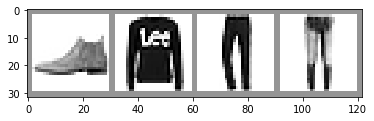

In [13]:
dataiter = iter(testloader)

inputs, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(inputs)
matplotlib_imshow(img_grid, one_channel=True)
print('groundtruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('acc: %d %%' % (100 * correct/total))

acc: 10 %


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('acc of %5s : %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))

acc of T-shirt/top :  0 %
acc of trouser :  0 %
acc of pullover : 100 %
acc of dress :  0 %
acc of  coat :  0 %
acc of sandal :  0 %
acc of shirt :  0 %
acc of sneaker :  0 %
acc of   bag :  0 %
acc of ankle boot :  0 %
